In [1]:
from seisray.core.earth_models import EarthModelManager

In [2]:
models = EarthModelManager()
model = models.get_model('iasp91')
print(model)

### Plotting the 1D Earth model

You can visualize the 1D profiles (e.g., Vp and Vs vs. depth) for any TauP model using `EarthModelManager.plot_1d_profile()`. The example below plots Vp and Vs for `iasp91` down to 700 km depth.

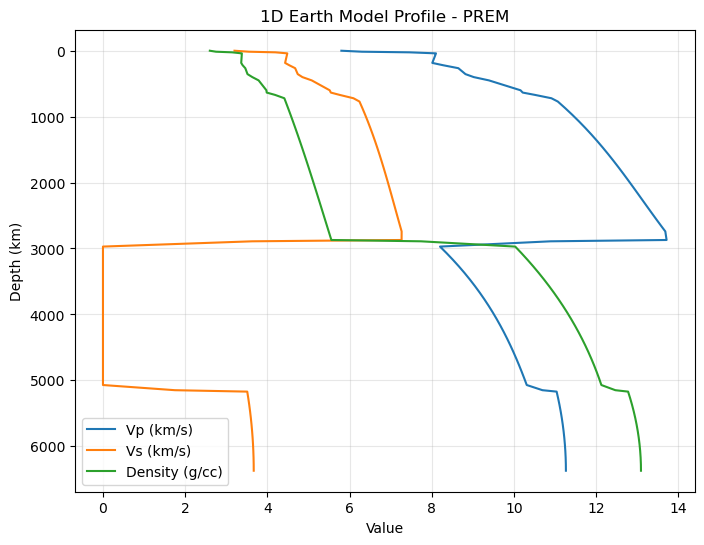

In [9]:
# Visualize 1D Earth model profiles (Vp, Vs) for iasp91
import matplotlib.pyplot as plt
from seisray.core.earth_models import EarthModelManager

emm = EarthModelManager()
emm.plot_1d_profile('prem', properties=['vp','vs', 'rho'], max_depth_km=6371)
plt.show()